<a href="https://colab.research.google.com/github/lanceaquino/CS146/blob/main/CS146_LBA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS146 LBA: Grocery Data 

For this assignment, we are going to look into the different grocery products at varying locations, grocery price level, and location. The different products will then be analyzed with respect to their average rental price. This can help us determine the relationship of the rental price to grocery product price. 

The products that will be analyzed will be: 
1. Apples
2. Bananas 
3. Tomatoes 
4. Potatoes 
5. Flour, white 
6. Rice, basmati 
7. Milk, full cream 
8. Butter 
9. Eggs 
10. Chicken breasts 



## Data Pre-processing

### Processing in Google Sheets

Before the data is imported to Python, I made some edits in the google sheet by removing insignificant columns (e.g. name, date of submission, etc) and converted all the currencies to USD so we can easily analyze the values after import. 

### Processing in Python

Here, we continue to make changes using Pandas. Please note that all prices are converted to USD 

In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as sts
import matplotlib.pyplot as plt 
import pystan 
import seaborn as sns


In [2]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQ6wBw2rwqzHoKYTnvInezGV-SHluP5csWohoc918xVhNqPN5hxLyOHzoiaw3mHQHZkIai8m_0dFIpg/pub?gid=1523904063&single=true&output=csv")

# Clean data 

# Replace headers for easier data parsing 
headers = ["country", "currency", "store_name", "price_perception", "avg_rental_price",
           "quant_apples1", "price_apples1", "quant_apples2", "price_apples2", "quant_apples3", "price_apples3",
           "quant_bananas1", "price_bananas1", "quant_bananas2", "price_bananas2", "quant_bananas3", "price_bananas3",
           "quant_tomatoes1", "price_tomatoes1", "quant_tomatoes2", "price_tomatoes2", "quant_tomatoes3", "price_tomatoes3", 
           "quant_potatoes1", "price_potatoes1", "quant_potatoes2", "price_potatoes2", "quant_potatoes3", "price_potatoes3",
           "quant_flour1", "price_flour1", "quant_flour2", "price_flour2", "quant_flour3", "price_flour3", 
           "quant_rice1", "price_rice1", "quant_rice2", "price_rice2", "quant_rice3", "price_rice3", 
           "quant_milk1", "price_milk1", "quant_milk2", "price_milk2", "quant_milk3", "price_milk3",
           "quant_butter1", "price_butter1", "quant_butter2", "price_butter2", "quant_butter3", "price_butter3", 
           "quant_eggs1", "price_eggs1", "quant_eggs2", "price_eggs2", "quant_eggs3", "price_eggs3",
           "quant_chicken1", "price_chicken1", "quant_chicken2", "price_chicken2", "quant_chicken3", "price_chicken3"]

df.columns = headers

# Adjust price perception of each stores 
price_levels = {"Budget (cheap)" : "cheap", "Mid-range" : "mid", "Luxury (expensive)" : "expensive"}
new_price_perception = {"price_perception" : price_levels}
df.replace(new_price_perception, inplace = True)

# Adjust countries 
diff_countries = {"Canada" : "Canada", "United States" : "US", "USA" : "US", "Sweden": "Sweden", 
                  "Ukraine" : "Ukraine", "USA" : "US", "US" : "US", "USA (San Francisco)" : "US", "Kenya" : "Kenya", 
                  "Brazil" : "Brazil", "United States of America" : "US", "Dallas, TX, USA" : "US", "San Francisco, USA" : "US",
                  "San Francisco" : "US", "United States " : "US", "Bangladesh" : "Bangladesh", "San Francisco, United States" : "US"}
keys_diff_counties = {'country' : diff_countries}
df.replace(keys_diff_counties, inplace= True)

# Adjust outlier with unique input for price perception 
df.iloc[30, 3]  = 'expensive'

# Show first three data points 
df.head(n = 3)


,country,currency,store_name,price_perception,avg_rental_price,quant_apples1,price_apples1,quant_apples2,price_apples2,quant_apples3,price_apples3,quant_bananas1,price_bananas1,quant_bananas2,price_bananas2,quant_bananas3,price_bananas3,quant_tomatoes1,price_tomatoes1,quant_tomatoes2,price_tomatoes2,quant_tomatoes3,price_tomatoes3,quant_potatoes1,price_potatoes1,quant_potatoes2,price_potatoes2,quant_potatoes3,price_potatoes3,quant_flour1,price_flour1,quant_flour2,price_flour2,quant_flour3,price_flour3,quant_rice1,price_rice1,quant_rice2,price_rice2,quant_rice3,price_rice3,quant_milk1,price_milk1,quant_milk2,price_milk2,quant_milk3,price_milk3,quant_butter1,price_butter1,quant_butter2,price_butter2,quant_butter3,price_butter3,quant_eggs1,price_eggs1,quant_eggs2,price_eggs2,quant_eggs3,price_eggs3,quant_chicken1,price_chicken1,quant_chicken2,price_chicken2,quant_chicken3,price_chicken3
0,Canada,CAD,Thrifty's,cheap,1162.53025,1.360,3.808289,1.360,4.000708,1.360,3.808289,0.19,0.264576,0.18,0.376820,0.08,0.280611,0.230,1.419089,0.454,4.802453,0.18,2.220834,0.100,0.352768,0.10,0.352768,1.00,2.469375,2.500,6.005070,2.50,3.198963,10.00,11.216413,1.60,10.414668,0.24,3.599835,0.907,4.241231,2.00,5.203325,4.00,5.203325,1.50,4.241231,0.454,3.599835,0.454,5.203325,0.454,6.005070,18.0,7.255792,18.0,6.566292,12.0,4.610034,0.400,7.416141,0.600,13.028356,0.780,13.084478
1,Canada,CAD,Save on Foods,cheap,1242.70475,0.100,0.529152,0.100,0.352768,0.100,0.705536,0.10,0.136297,0.10,0.160349,0.10,0.529152,0.100,0.529152,0.100,0.617344,0.10,0.529152,0.100,0.248541,0.10,0.352768,0.10,0.144314,10.000,10.414668,2.00,8.009433,1.00,4.000708,0.10,0.232506,4.54,16.026883,2.000,8.009433,1.00,3.359312,1.00,2.084537,4.00,4.241231,0.454,3.519661,0.454,4.561929,0.454,6.165419,12.0,4.369510,12.0,6.005070,12.0,6.165419,3.000,18.504275,0.100,0.970111,0.500,9.709132
2,US,USD,Target,mid,2996.00000,1.361,4.690000,1.361,3.590000,1.361,2.990000,0.91,1.790000,0.12,0.250000,NaN,NaN,0.454,3.190000,0.454,1.290000,0.30,2.990000,2.268,2.590000,0.68,4.990000,0.68,3.990000,2.268,3.690000,0.91,1.890000,0.91,10.990000,0.24,1.390000,0.85,5.990000,0.910,3.290000,1.89,2.190000,1.89,1.990000,1.67,3.990000,0.430,2.290000,0.450,3.690000,0.370,5.290000,12.0,1.690000,18.0,2.390000,12.0,3.990000,0.454,5.990000,1.134,8.590000,1.814,8.490000


### Overview of the data that we have 

In [3]:
print("Total data points:", df.shape[0])
print("--")

print("Number of data points per country:")
for country in df['country'].unique():
  print(country,":", len(df[df['country'] == country]))
print("--")

print("Currencies:", df['currency'].unique(), 'Total:', df['currency'].nunique())
print("--")

print("Countries:", df['country'].unique(), 'Total:', df['country'].nunique())
print("Price Categories:", df['price_perception'].unique(), 'Total:', df['price_perception'].nunique())

Total data points: 53
--
Number of data points per country:
Canada : 2
US : 38
Sweden : 2
Ukraine : 4
Kenya : 1
Brazil : 4
Bangladesh : 2
--
Currencies: ['CAD' 'USD' 'SEK' 'UAH' 'KES' 'BRL' 'BDT'] Total: 7
--
Countries: ['Canada' 'US' 'Sweden' 'Ukraine' 'Kenya' 'Brazil' 'Bangladesh'] Total: 7
Price Categories: ['cheap' 'mid' 'expensive'] Total: 3


### Modifying data set to only allow one product per row 

Here, we are going to shift the data set into having only one product per row. This allows us to easily input the data in the Stan model. 

In [4]:
# Create new columns for the newly formed data frame 
new_cols = [['country', 'category', 'product', 'quantity', 'price']]

# Craete list to keep track of the products that we are currently inputing 
products = ['apples','bananas','tomatoes','potatoes','flour','rice','milk','butter','eggs','chicken']

# Acquire total dimensions
# Our method is that we are getting one product with respective country and price category
# 10 products * 3 categories 
n = 30

# We shift the data set with their respective product rows 
for i in range(df.shape[0]*n):
    product = products[i // 3 % 10]
    new_cols.append([df.iloc[i//n]['country'],
                  df.iloc[i//n]['price_perception'], product,
                  df.iloc[i//n][i%n*2 + 5], df.iloc[i//n][i%n*2 + 6]])
    
# Create new data frame for the newly formed columns 
new_df = pd.DataFrame(new_cols[1:],columns=new_cols[0])
new_df 

,country,category,product,quantity,price
0,Canada,cheap,apples,1.36,3.808289
1,Canada,cheap,apples,1.36,4.000708
2,Canada,cheap,apples,1.36,3.808289
3,Canada,cheap,bananas,0.19,0.264576
4,Canada,cheap,bananas,0.18,0.376820
...,...,...,...,...,...
1585,US,mid,eggs,1.00,0.400000
1586,US,mid,eggs,1.00,0.230000
1587,US,mid,chicken,0.45,3.490000
1588,US,mid,chicken,0.45,7.990000


In [5]:

# Since we already have one product per row, we can just remove the rows with no values 
# by basically dropping them 
new_df.dropna(inplace=True)

# Dropping rows doesn't change index and therefore we need to reset our index
new_df.reset_index(drop=True, inplace=True)

# We also add a new column that has a standardized price
# Here, we are getting the price per quantity (e.g. price/kilo, price/liter, price/count)
new_df['unit_cost'] = new_df['price'] / new_df['quantity']
new_df



INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,country,category,product,quantity,price,unit_cost
0,Canada,cheap,apples,1.36,3.808289,2.800212
1,Canada,cheap,apples,1.36,4.000708,2.941697
2,Canada,cheap,apples,1.36,3.808289,2.800212
3,Canada,cheap,bananas,0.19,0.264576,1.392504
4,Canada,cheap,bananas,0.18,0.376820,2.093445
...,...,...,...,...,...,...
1378,US,mid,eggs,1.00,0.400000,0.400000
1379,US,mid,eggs,1.00,0.230000,0.230000
1380,US,mid,chicken,0.45,3.490000,7.755556
1381,US,mid,chicken,0.45,7.990000,17.755556


In [6]:
# Add product, country and category code for easier parsing of the data 
# We incldue (+ 1) since Stan does indexing at 1 

products = list(new_df['product'].unique())
countries = list(new_df['country'].unique())
categories = list(new_df['category'].unique())

new_df['product_code'] = [products.index(i) + 1 for i in new_df['product']]
new_df['country_code'] = [countries.index(i) + 1 for i in new_df['country']]
new_df['category_code'] = [categories.index(i) + 1 for i in new_df['category']]
new_df.sample(n = 5)

,country,category,product,quantity,price,unit_cost,product_code,country_code,category_code
606,US,mid,tomatoes,0.450,2.29,5.088889,3,2,2
1150,US,cheap,flour,0.453,0.99,2.185430,5,2,1
591,US,mid,butter,0.453,8.50,18.763797,8,2,2
543,US,cheap,bananas,1.000,1.69,1.690000,2,2,1
462,US,mid,apples,0.160,0.63,3.937500,1,2,2


In [7]:
stan_code = '''

data {
    int<lower=1> num_units;                       // number of data points 
    real<lower=0> unit_cost[num_units];            // cost per unit 
    
    int<lower=1> num_products;                    // number of products
    int<lower=0> product_code[num_units];         // product code


    int<lower=1> num_countries;                   // number of countries
    int<lower=0> country_code[num_units];         // product code

    int<lower=1> num_cats;                        // number of categories 
    int<lower=0> cat_code[num_units];             // category code
}

parameters {
    real<lower=0> base_price[num_products];       // base price estimate
    real<lower=0> cost_var;                       // base price variance 
    real<lower=0> scale_country[num_countries];   // multiplier for countries estimate
    real<lower=0> scale_cat[num_cats];            // multiplier for categories estimate 
}

model {
    scale_country ~ normal(1,0.1);                // prior, not truncated because bounds have been set 
    scale_cat ~ normal(1,0.1);                    // prior

    for(i in 1:num_units){
        unit_cost[i] ~ normal(base_price[product_code[i]]*scale_country[country_code[i]]*scale_cat[cat_code[i]], sqrt(cost_var));
    }  
}
'''

In [8]:
#inputting data for stan model
stan_data = {
    'num_units': new_df.shape[0],
    'unit_cost': list(new_df['unit_cost']),

    'num_products': new_df['product'].nunique(),
    'product_code': list(new_df['product_code']),

    'num_countries': new_df['country'].nunique(),
    'country_code': list(new_df['country_code']),

    'num_cats': new_df['category'].nunique(),
    'cat_code':list(new_df['category_code'])
}

# Implement Stan Model 
stan_model = pystan.StanModel(model_code=stan_code)

# Generate Posterior Samples 
results = stan_model.sampling(data=stan_data)

print(results)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ebd4dabca79545b106e26da37c8492e NOW.


Inference for Stan model: anon_model_7ebd4dabca79545b106e26da37c8492e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]      4.72    0.02   0.52   3.77   4.36    4.7   5.05   5.81   1059    1.0
base_price[2]      2.48  9.7e-3   0.41   1.71   2.21   2.47   2.74   3.35   1761    1.0
base_price[3]      5.94    0.02    0.6   4.84   5.53   5.91   6.33   7.21   1021    1.0
base_price[4]      3.02    0.01   0.42   2.27   2.72   2.99   3.29   3.89   1594    1.0
base_price[5]      3.04    0.01   0.41   2.29   2.76   3.01   3.31    3.9   1491    1.0
base_price[6]      4.93    0.02   0.53   3.98   4.58   4.92   5.27   6.04   1057    1.0
base_price[7]      2.01  8.4e-3   0.37   1.32   1.77    2.0   2.26   2.78   1923    1.0
base_price[8]     12.95    0.04   1.15  10.89  12.14  12.88  13.68  15.36    827    1.0
base_price[9]      

In [14]:
# We extract the values of interests from the results of the stan model 
# Here, we are acquiring the mean, sd, and upper and lower bounds 
# ofthe 95% confidence interval 

base_prices = np.array([[i[0], i[2], i[3], i[7]] 
                       for i in results.summary()['summary'][0:len(products)]])

country_scales = np.array([[i[0], i[2], i[3], i[7]]
                       for i in results.summary()['summary']
                       [len(products)+1:len(products)+1+len(countries)]])

category_scales = np.array([[i[0], i[2], i[3], i[7]]
                       for i in results.summary()['summary']
                       [len(products)+len(countries)+1:-1]])

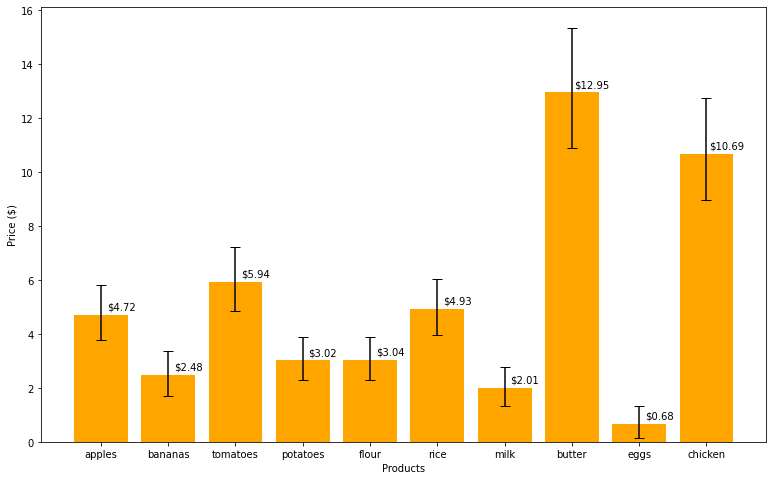

In [23]:
# Plotting Base Prices 

product_err = []

for point in range(base_prices.shape[0]):
  mean = base_prices[point,0]
  product_err.append((mean - base_prices[point,2], base_prices[point,3] - mean))

product_err = np.array(product_err)

plt.figure(figsize = (13,8))
# plt.title("Base Product Price with 95% Confidence Interval Error Bar")
plt.xlabel("Products")
plt.ylabel("Price ($)")
product_bar = plt.bar(products, base_prices[:,0], yerr = product_err.transpose(), color = 'orange',
        capsize = 5)
# for i in range(len(products)):
#     plt.annotate(np.around(base_prices[:,0][i], 2), (base_prices[:, 0][i], i))

def autolabel(bar_data):
    """
    This function automatically adds the label of the bar graphs 
    based on the height and width of the bar graphs 

    Input:
      bar_data - the plt result of the bar graph 

    Output:
      Annotations 
    """
    for data in bar_data:
        height = data.get_height()
        plt.annotate(f'${np.round(height, 2)}',
                    xy=(data.get_x() + data.get_width() / 2 + 0.3, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(product_bar)

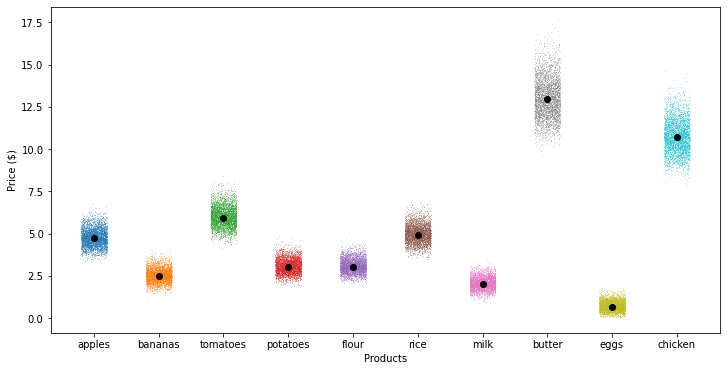

In [25]:
plt.figure(figsize=(12,6))

for i in range(len(products)):
    plt.plot(sts.uniform.rvs(loc = i+0.8, scale = 0.4, size = 4000), 
             results['base_price'][:,i], 
             ',', alpha = 0.3)
    
    plt.plot(range(1, 1 + len(products))[i],
             results['base_price'][:,i].mean(axis=0),
             marker='o', color="black")

# plt.title('Base Unit Price Posterior Samples')
plt.xticks(range(1, 1+ len(products)), list(products))
plt.xlabel("Products")
plt.ylabel("Price ($)")
plt.show()

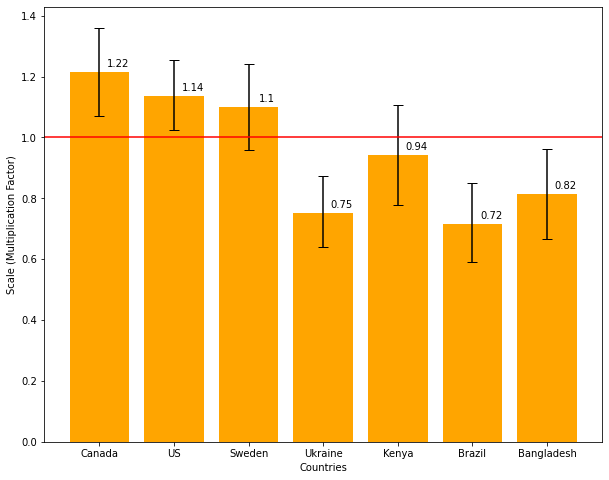

In [27]:

# Plotting Country Factors

product_err = []

for point in range(country_scales.shape[0]):
  mean = country_scales[point,0]
  product_err.append((mean - country_scales[point,2], country_scales[point,3] - mean))

product_err = np.array(product_err)

plt.figure(figsize = (10,8))
# plt.title("Base Product Price with 95% Confidence Interval Error Bar")
plt.xlabel("Countries")
plt.ylabel("Scale (Multiplication Factor)")
country_bar = plt.bar(countries, country_scales[:,0], yerr = product_err.transpose(), color = 'orange',
        capsize = 5)

def autolabel_2(bar_data):
    """
    This function automatically adds the label of the bar graphs 
    based on the height and width of the bar graphs. The only
    difference is that this does not add the dollar sign ($)

    Input:
      bar_data - the plt result of the bar graph 

    Output:
      Annotations 
    """
    for data in bar_data:
        height = data.get_height()
        plt.annotate(f'{np.round(height, 2)}',
                    xy=(data.get_x() + data.get_width() / 2 + 0.25, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
plt.axhline(1, color = 'red')

autolabel_2(country_bar)

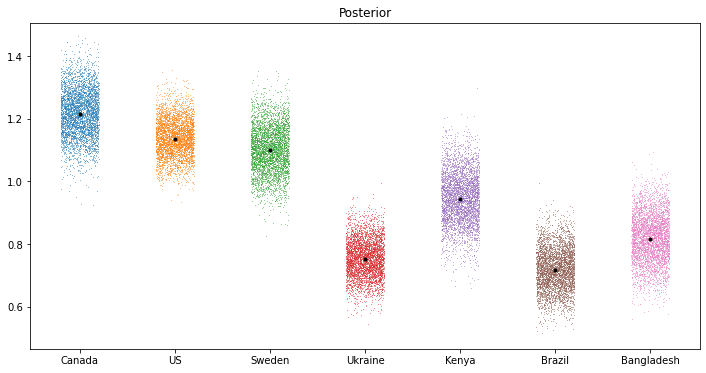

In [18]:
plt.figure(figsize=(12,6))

for i in range(len(countries)):
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.4, size=4000), 
             results['scale_country'][:,i], 
             ',', alpha=0.5)
    plt.plot(range(1, 1 + len(list(new_df['country_code'])))[i],
             results['scale_country'][:,i].mean(axis=0), 
         marker='.', color="black")

# plt.title('Posterior')
plt.xticks(range(1, 1+ len(countries)), list(countries))

plt.show()

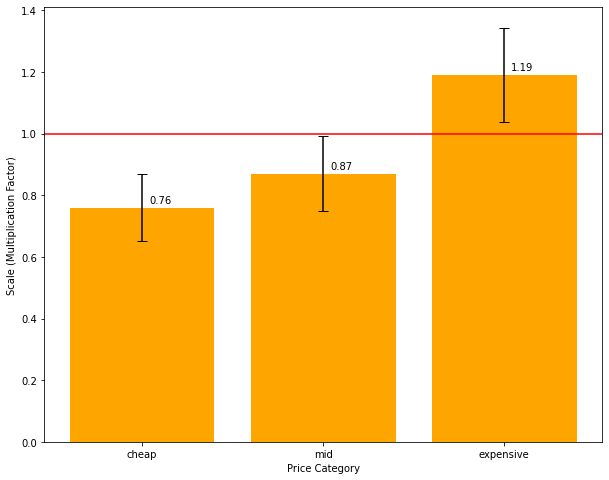

In [28]:
# Plotting Price Perception Category Factors 

product_err = []

for point in range(category_scales.shape[0]):
  mean = category_scales[point,0]
  product_err.append((mean - category_scales[point,2], category_scales[point,3] - mean))

product_err = np.array(product_err)

plt.figure(figsize = (10,8))
# plt.title("Base Product Price with 95% Confidence Interval Error Bar")
plt.xlabel("Price Category")
plt.ylabel("Scale (Multiplication Factor)")
category_bar = plt.bar(categories, category_scales[:,0], yerr = product_err.transpose(), color = 'orange',
        capsize = 5)

plt.axhline(1, color = 'red')

def autolabel_3(bar_data):
    """
    This function automatically adds the label of the bar graphs 
    based on the height and width of the bar graphs. The only
    difference is that this does not add the dollar sign ($). 
    Also, we adjusted for the big widths.

    Input:
      bar_data - the plt result of the bar graph 

    Output:
      Annotations 
    """
    for data in bar_data:
        height = data.get_height()
        plt.annotate(f'{np.round(height, 2)}',
                    xy=(data.get_x() + data.get_width() / 2 + 0.1, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_3(category_bar)

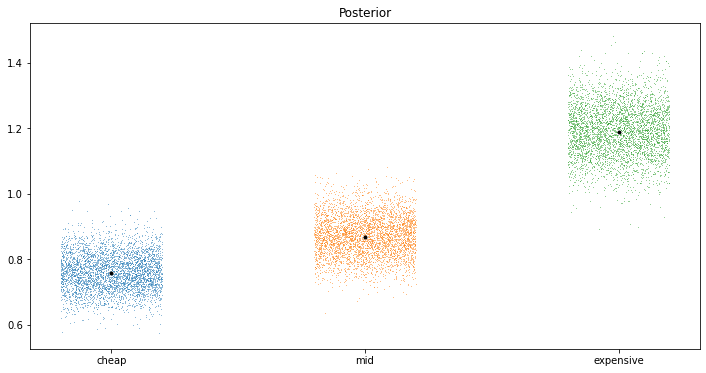

In [20]:
plt.figure(figsize=(12,6))

for i in range(len(categories)):
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.4, size=4000), 
             results['scale_cat'][:,i], 
             ',', alpha=0.5)
    plt.plot(range(1, 1 + len(list(new_df['category_code'])))[i],
             results['scale_cat'][:,i].mean(axis=0), 
         marker='.', color="black")

plt.title('Posterior')
plt.xticks(range(1, 1+ len(categories)), list(categories))

plt.show()

### Acquiring correlation between rental price and geographical location 

In [83]:
country_scale_factor = results['scale_country'][0,:]
avg_rents = []

for country  in df['country'].unique():
  curr_country_df = df[df['country'] == country]

  avg_rents.append(np.mean(curr_country_df['avg_rental_price']))

corr_coef = np.corrcoef(country_scale_factor, avg_rents)[0][1]
print("Pearson's R:", np.round(corr_coef, 2))
print("R-squared:", np.round(corr_coef**2, 2))

Pearson's R: 0.72
R-squared: 0.51
